In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, MACCSkeys, rdFMCS, PandasTools
import matplotlib.pyplot as plt
from lib import preprocess_Chembl_data
from lib import OpenSMILES_grammar

(array([2192., 4128., 6894., 6534., 6306., 7508., 6859., 4962., 3403.,
        1681.]),
 array([-5.08 , -3.443, -1.806, -0.169,  1.468,  3.105,  4.742,  6.379,
         8.016,  9.653, 11.29 ]),
 <BarContainer object of 10 artists>)

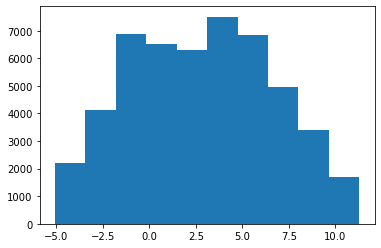

In [2]:
data = pd.read_csv('data/lipo_balanced_training_unique.csv')
plt.hist(data['GenExp'])

In [16]:
translate = preprocess_Chembl_data.translate
smiles2dummies = preprocess_Chembl_data.smiles2dummies
dummies2smiles = preprocess_Chembl_data.dummies2smiles
charset = sorted(preprocess_Chembl_data.chembl_charset + ['L', 'X', 'Y', 'e', 'K', 'U', 'G'])
max_seq_length = preprocess_Chembl_data.chembl_max_seq_length
num_tokens = len(charset)
num_decoder_tokens = OpenSMILES_grammar.D
token_index = dict(
    [(char, i) for i, char in enumerate(charset)])

L1000_input_smiles = data.input_smiles.values
encoder_input_tokens = np.array([np.array([token_index[char] for char in mol], dtype=int) 
                               for mol in L1000_input_smiles])

L1000_encoder_input_data = np.zeros((len(L1000_input_smiles), max_seq_length, num_tokens), dtype='float32')
for i in range(len(L1000_input_smiles)):
    num_chars = len(encoder_input_tokens[i])
    L1000_encoder_input_data[i][np.arange(num_chars),encoder_input_tokens[i]] = 1.

print('Number of total samples:', len(L1000_input_smiles))
print('Number of unique input tokens:', num_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_seq_length)
print('Shape encoder input One-Hot encoding:', L1000_encoder_input_data.shape)

Number of total samples: 50467
Number of unique input tokens: 61
Number of unique output tokens: 107
Max sequence length for inputs: 120
Shape encoder input One-Hot encoding: (50467, 120, 61)


## Load AutoEncoder

In [19]:
import warnings
import numpy as np
import tensorflow as tf
# from lib.Models_New import build_encoder_decoder
from lib.Models_New_without_info_loss import build_encoder_decoder
warnings.filterwarnings('ignore')
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True


tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
model, encoder_model, decoder_model = build_encoder_decoder(num_tokens=num_tokens, NCHARS = num_decoder_tokens,
                                                            weights='models/mol2grammar_1GRU_256_dropout',
                                                            latent_dim= 256, verbose = False)

2022-08-28 23:00:48.867595: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/mol2grammar_1GRU_256_dropout: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [20]:
np.random.seed(0)
data['states'] = np.expand_dims(encoder_model.predict(L1000_encoder_input_data, verbose=1), axis=1).tolist()
data.head()
data.to_csv("data/output_data.csv")

1578/1578 [==============================] - 107s 67ms/step


In [30]:
data.head()

,pert_iname,input_smiles,GenExp,included,accept_length,states
0,100136,N[C@@H](CSSC[C@H](N)C(O)=O)C(O)=O,-5.08,True,True,"[[0.06230200454592705, 0.09849172830581665, -0..."
1,100610,Nc1cc(N)c(cc1)S(O)(=O)=O,-4.65,True,True,"[[0.009378821589052677, -0.0020040320232510567..."
2,101753,OC(=O)C(N)CCN,-4.64,True,True,"[[0.17924384772777557, -0.007317966315895319, ..."
3,106334,OP(O)(=O)CN(CP(O)(O)=O)CCCCCCN(CP(O)(O)=O)CP(O...,-4.43,True,True,"[[-0.09266526252031326, -0.0772615522146225, -..."
4,100319,O=C(O)C(N)CCCN,-4.22,True,True,"[[0.17377588152885437, -0.05099713057279587, -..."


In [27]:
a = np.expand_dims(encoder_model.predict(L1000_encoder_input_data, verbose=1), axis=1)

1578/1578 [==============================] - 103s 65ms/step


In [29]:
a.shape

(50467, 1, 256)

In [22]:
a = list(data['states'])

## Decode

In [6]:
import os
import glob
from lib.Utils_lipo import getSMILES
from lib.rdkit_master.Contrib.SA_Score import sascorer
from rdkit import Chem, DataStructs

In [7]:
df_condition = pd.read_csv('data/lipo_balanced_condition_unique.csv')
print(df_condition['GenExp'].mean())
condition = np.asarray([3.0])
smiles_actives = df_condition['input_smiles'].tolist()
trials = 5000
mols_actives = [Chem.MolFromSmiles(mol) for mol in smiles_actives]
ecfps_actives = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024, useChirality=True) for mol in mols_actives]
maccs_actives = [MACCSkeys.GenMACCSKeys(mol) for mol in mols_actives]

2.7850628529534345


In [8]:
sample_dir = '/Users/mona/GitClone/Diffuse/data/samples_100_v2'
sample_path = glob.glob(os.path.join(sample_dir, '*.npy'))
samples = [np.load(x) for x in sample_path]
print(f"Number of samples: {len(samples)}, dims of each sample: {samples[0].shape}")

samples = np.stack(samples)
print(f"samples shape {samples.shape}")

Number of samples: 100, dims of each sample: (256,)
samples shape (100, 256)


In [32]:
samples

array([[0.41432333, 0.44181493, 0.50545555, ..., 0.35376814, 0.7171818 ,
        0.6687947 ],
       [0.3344016 , 0.5069134 , 0.4692589 , ..., 0.34573293, 0.5618521 ,
        0.70529884],
       [0.4652025 , 0.4861829 , 0.4821378 , ..., 0.3091187 , 0.63103276,
        0.49203515],
       ...,
       [0.5286651 , 0.47665507, 0.43904796, ..., 0.37645662, 0.5684196 ,
        0.523644  ],
       [0.35753468, 0.482711  , 0.49890196, ..., 0.32234234, 0.67561257,
        0.5447184 ],
       [0.3741781 , 0.5006781 , 0.55524665, ..., 0.3568912 , 0.50253016,
        0.48370722]], dtype=float32)

In [31]:
pred_smiles1 = getSMILES(samples, decoder_model=decoder_model, use_grammar=True)

4/4 [==============================] - 0s 5ms/step


In [10]:
pred_smiles1

['NCOCC',
 'NCNC',
 'NNC',
 'NCNCC',
 'NNCCCC',
 'NNC',
 'NCNC',
 'NCOCC',
 'NNCCC',
 'NCNC',
 'NNCCC',
 'NCNCCC',
 'NCNCCC',
 'NCOCCC',
 'NNCCCCC',
 'NC',
 'NCNCC',
 'NCNCCCC',
 'NCNCC',
 'NCNC',
 'NNCC',
 'NCNCC',
 'NCOCCCC',
 'NNCC',
 'NNOCCCC',
 'NCOC',
 'NCOC',
 'NCOC',
 'NCNC',
 'NCCOCCC',
 'NCNCCC',
 'NCNC',
 'ONCCCCC',
 'NCOC',
 'NCNCC',
 'NCNC',
 'NCNCC',
 'NCNCC',
 'NCNCCC',
 'NNCCC',
 'NCNCCC',
 'NCOCCCC',
 'NNCC',
 'NCNC',
 'NCNC',
 'NCNCC',
 'NNCCC',
 'NNOCC',
 'NNCC',
 'NCNCC',
 'NCOCCC',
 'NCNCC',
 'NNCCCC',
 'NNCC',
 'NCNCC',
 'NNCC',
 'NCOCC',
 'NCOC',
 'NCOC',
 'NCNC',
 'NNCCO',
 'NCNCC',
 'NCNCCC',
 'NCOCCC',
 'NNCC',
 'NCNCC',
 'NCNCC',
 'NNCC',
 'NCNCC',
 'NCNCC',
 'NCNCC',
 'NCNC',
 'NCNCC',
 'NCNCCCC',
 'NCNCC',
 'NCNC',
 'NNCCCCC',
 'NCNC',
 'NCNCC',
 'NNCCCC',
 'NCNCC',
 'NCNCC',
 'NOCCCCC',
 'NCOCCC',
 'NCOCCC',
 'NCOCC',
 'NCNC',
 'NCNC',
 'NNCCCC',
 'NCNCCC',
 'NCCOC',
 'NNCCC',
 'NNCCC',
 'NCNCCCC',
 'NCOCCC',
 'NCNCC',
 'NCNCC',
 'NNOC',
 'NCOCC',
 'NCNC']

In [11]:
mols1_used_index = [] # will be used to index pre_smiles
mols1_used = []
mol1_list = []
for id_, smile in enumerate(pred_smiles1):
    if Chem.MolFromSmiles(smile) is not None and Chem.MolFromSmiles(smile) not in mols1_used:
        mols1_used_index.append(id_)
        mols1_used.append(Chem.MolFromSmiles(smile))

In [12]:
mols1 = mols1_used 
valid_smiles1 = len(mols1)
unique_smiles1 = len(set([Chem.MolToSmiles(m) for m in mols1]))

mols1_used_index_acc = []
mols1_acc = []

for idx_, mol_ in enumerate(mols1):
    if sascorer.calculateScore(mol_) <= 4.5:
        mols1_acc.append(mol_)
        mols1_used_index_acc.append(mols1_used_index[idx_])

mols1 = mols1_acc
print("mols1 length: ", len(mols1))
if mol1_list == []:
    mol1_list = mols1
else:
    mol1_list += mols1


mols1 length:  100


In [13]:
mols1 = mol1_list
ecfps_smiles1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, 1024, useChirality=True) for mol in mols1]
maccs_smiles1 = [MACCSkeys.GenMACCSKeys(mol) for mol in mols1]


#Evaluate diversity and Nearest Neigbours between active compounds and generated molecules
ecfps_SimMat1 = [DataStructs.BulkTanimotoSimilarity(fp, ecfps_actives) for fp in ecfps_smiles1]
maccs_SimMat1 = [DataStructs.BulkTanimotoSimilarity(fp, maccs_actives) for fp in maccs_smiles1]

Valid new generation from first generator and mean logp of generation: 20 -0.059729999999999964


(array([1., 0., 2., 3., 2., 3., 4., 1., 2., 2.]),
 array([-1.558  , -1.28666, -1.01532, -0.74398, -0.47264, -0.2013 ,
         0.07004,  0.34138,  0.61272,  0.88406,  1.1554 ]),
 <BarContainer object of 10 artists>)

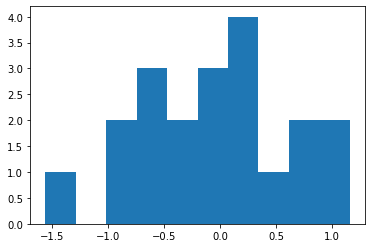

In [14]:
unique_smiles1_set = set([Chem.MolToSmiles(m) for m in mols1])

new_smile = []
unique_smile_logp = []
unique_smile_logp_valid = [] # record valid smiles (that can transfer from mol to smile)
new_unique_smile_logp_valid = [] # decide if the smile is valid and new comparing to training dataset

for smile in unique_smiles1_set:
    smile_valid = False
    if Chem.MolFromSmiles(smile) is not None:
        mol = Chem.MolFromSmiles(smile)
        unique_smile_logp.append(Chem.Crippen.MolLogP(mol))
        unique_smile_logp_valid.append(smile)
        smile_valid = True
        
    if smile not in df_condition['input_smiles'].tolist():
        new_smile.append(smile)
        if smile_valid:
            new_unique_smile_logp_valid.append(1)

    else:
        if smile_valid:
            new_unique_smile_logp_valid.append(0)
            

df = pd.DataFrame(unique_smile_logp_valid, columns =['diffusion_output'])
df['logp'] = unique_smile_logp
df['valid_new'] = new_unique_smile_logp_valid
df.to_csv("diffusion_output.csv")

new_smile_logp = np.zeros(len(new_smile))
for idx, smile in enumerate(new_smile):
    if Chem.MolFromSmiles(smile) is not None:
        mol = Chem.MolFromSmiles(smile)
        new_smile_logp[idx] = Chem.Crippen.MolLogP(mol)
print("Valid new generation from first generator and mean logp of generation:", np.count_nonzero(new_smile_logp), np.mean(new_smile_logp))
plt.hist(new_smile_logp)

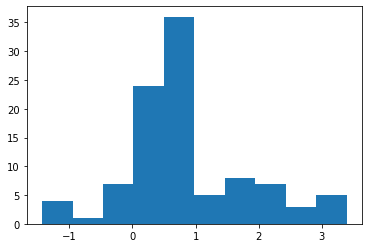

0.8185000000000001
-0.31012900000000004
100


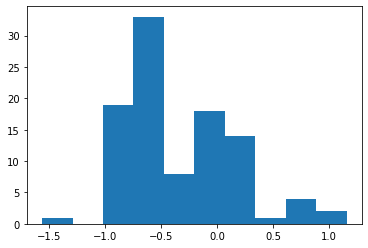

In [15]:
closest_neighbor_index_list1 = []
closest_neighbor_similarity_list1 = []
rdkit_logp_list1 = []
for i in range(len(ecfps_SimMat1)):
    closest_neighbor_index_list1.append(np.where(ecfps_SimMat1[i] == np.max(ecfps_SimMat1[i]))[0][0])
    closest_neighbor_similarity_list1.append(np.max(ecfps_SimMat1[i]))
    rdkit_logp_list1.append(Chem.Crippen.MolLogP(mols1[i]))
closest_neighbor_exp_list1 = []
for i in closest_neighbor_index_list1:
    closest_neighbor_exp_list1.append(df_condition['GenExp'][i])
# exp = 1
plt.hist(closest_neighbor_exp_list1)
plt.show()
plt.hist(rdkit_logp_list1)
print(np.mean(closest_neighbor_exp_list1)) # the logp of closest neighbor in training dataset (from G1)
print(np.mean(rdkit_logp_list1)) # the calculated logp (from G1)
print(len(closest_neighbor_exp_list1))

In [33]:
new_smile_logp

array([-0.1403,  0.3292,  0.2498,  1.1554, -0.9889,  0.2923, -0.4879,
       -0.878 , -0.4085,  0.3717, -0.0978,  0.1814, -0.5304, -0.5988,
       -0.451 , -0.0609,  1.0669, -1.558 ,  0.7193,  0.6399])

In [35]:
len(unique_smiles1_set)

22